# **Dependencies**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2, math

KEYPOINT_EDGES = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 4),
    (0, 5),
    (0, 6),
    (5, 7),
    (7, 9),
    (6, 8),
    (8, 10),
    (5, 6),
    (5, 11),
    (6, 12),
    (11, 12),
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16)
]

KEYPOINT_DICT = {
    'nose': (0, 1),
    'left_eye': (2, 3),
    'right_eye': (4, 5),
    'left_ear': (6, 7),
    'right_ear': (8, 9),
    'left_shoulder': (10, 11),
    'right_shoulder': (12, 13),
    'left_elbow': (14, 15),
    'right_elbow': (16, 17),
    'left_wrist': (18, 19),
    'right_wrist': (20, 21),
    'left_hip': (22, 23),
    'right_hip': (24, 25),
    'left_knee': (26, 27),
    'right_knee': (28, 29),
    'left_ankle': (30, 31),
    'right_ankle': (32, 33)
}

is_up_squat = False
is_down_squat = False
is_up_pushup = False
is_down_pushup = False

# **Load Sample Keypoints Model**
Load keypoints from an image as it is a frame of a video (image sequence)

In [ ]:
movenet_model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")

In [ ]:
def predict_keypoints(model, image_path):
    # Read image files and rersize it to 192x192
    image = tf.io.read_file(image_path)
    image = tf.compat.v1.image.decode_jpeg(image)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(tf.image.resize_with_pad(image, 192, 192), dtype=tf.int32)

    # Predict using movenet
    movenet = model.signatures["serving_default"]
    outputs = movenet(image)

    # Return keypoints in (1, 1, 17, 3)
    keypoints = outputs["output_0"]

    return image, keypoints

Funtion to get keypoints in 1D array

In [ ]:
def getKeypoints(keypoints_tensor):
  keys = []
  for keypoint in keypoints_tensor[0][0]:
            x = float(keypoint[1].numpy())
            y = float(keypoint[0].numpy())
            keys.append(x)
            keys.append(y)
  return keys

Display Keypoints

In [ ]:
from google.colab.patches import cv2_imshow

def display_keypoints(input_image, keypoints, width=512, height=512):
    input_image = tf.image.resize_with_pad(input_image, width, height)
    input_image = tf.cast(input_image, dtype=tf.uint8)

    npy_image = np.squeeze(input_image.numpy(), axis=0)
    npy_image = cv2.resize(npy_image, (width, height))
    npy_image = cv2.cvtColor(npy_image, cv2.COLOR_RGB2BGR)

    for keypoint in keypoints[0][0]:
        x = int(keypoint[1] * width)
        y = int(keypoint[0] * height)
        cv2.circle(npy_image, (x, y), 4, (0, 255, 255), -1)

    for edge in KEYPOINT_EDGES:
        x1 = int(keypoints[0][0][edge[0]][1] * width)
        y1 = int(keypoints[0][0][edge[0]][0] * height)
        x2 = int(keypoints[0][0][edge[1]][1] * width)
        y2 = int(keypoints[0][0][edge[1]][0] * height)
        cv2.line(npy_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    cv2_imshow(npy_image)
    cv2.waitKey()

# **Pushup Keypoints Calculator Functions**

In [ ]:
def armAngle(keypoints):
  left_wrist_index = KEYPOINT_DICT["left_wrist"]
  left_shoulder_index = KEYPOINT_DICT["left_shoulder"]
  left_elbow_index = KEYPOINT_DICT["left_elbow"]

  # Calculate angle between 3 points
  at1 = math.atan2(keypoints[left_wrist_index[1]] - keypoints[left_elbow_index[1]],
                     keypoints[left_wrist_index[0]] - keypoints[left_elbow_index[0]])
  at2 = math.atan2(keypoints[left_shoulder_index[1]] - keypoints[left_elbow_index[1]],
                     keypoints[left_shoulder_index[0]] - keypoints[left_elbow_index[0]])
  angle_tot = (at1 - at2) * (180/math.pi)
  return angle_tot

def backAngle(keypoints):
  left_hip_index = KEYPOINT_DICT["left_hip"]
  left_shoulder_index = KEYPOINT_DICT["left_shoulder"]
  left_knee_index = KEYPOINT_DICT["left_knee"]

  # Calculate angle between 3 points
  at1 = math.atan2(keypoints[left_knee_index[1]] - keypoints[left_hip_index[1]],
                     keypoints[left_knee_index[0]] - keypoints[left_hip_index[0]])
  at2 = math.atan2(keypoints[left_shoulder_index[1]] - keypoints[left_hip_index[1]],
                     keypoints[left_shoulder_index[0]] - keypoints[left_hip_index[0]])
  angle_tot = (at1 - at2) * (180/math.pi)
  return angle_tot

# **Squat Keypoints Calculator Functions**

In [ ]:
def kneeAngle(keypoints):
  left_hip_index = KEYPOINT_DICT["left_hip"]
  left_ankle_index = KEYPOINT_DICT["left_ankle"]
  left_knee_index = KEYPOINT_DICT["left_knee"]

  # Calculate angle between 3 points
  at1 = math.atan2(keypoints[left_ankle_index[1]] - keypoints[left_knee_index[1]],
                     keypoints[left_ankle_index[0]] - keypoints[left_knee_index[0]])
  at2 = math.atan2(keypoints[left_hip_index[1]] - keypoints[left_knee_index[1]],
                     keypoints[left_hip_index[0]] - keypoints[left_knee_index[0]])
  angle_tot = (at1 - at2) * (180/math.pi)
  return angle_tot

def hipAngle(keypoints):
  left_hip_index = KEYPOINT_DICT["left_hip"]
  left_shoulder_index = KEYPOINT_DICT["left_shoulder"]
  left_knee_index = KEYPOINT_DICT["left_knee"]

  # Calculate angle between 3 points
  at1 = math.atan2(keypoints[left_knee_index[1]] - keypoints[left_hip_index[1]],
                     keypoints[left_knee_index[0]] - keypoints[left_hip_index[0]])
  at2 = math.atan2(keypoints[left_shoulder_index[1]] - keypoints[left_hip_index[1]],
                     keypoints[left_shoulder_index[0]] - keypoints[left_hip_index[0]])
  angle_tot = (at1 - at2) * (180/math.pi)
  return angle_tot

# **Determine Form and Count Repetitions**
In this section we calculate angles based on classification output (either pushup or squat) 0 if the back is too backwards, 1 if right, 2 if the back is too bent

Pushup up and down detection

In [ ]:
def up_pushup(elbow_angle, reps_var):
  global is_up_pushup, is_down_pushup
  if not((abs(elbow_angle) > 170) and (abs(elbow_angle) < 200)):
    return reps_var

  if is_down_pushup:
    print("up")
    reps_var += 1

  is_up_pushup = True
  is_down_pushup = False

  return reps_var

def down_pushup(elbow_angle):
  global is_up_pushup, is_down_pushup
  if not((abs(elbow_angle) > 50) and (abs(elbow_angle < 90))):
    # exit function
    return None

  if is_up_pushup:
    print("down")

  is_up_pushup = False
  is_down_pushup = True

In [ ]:
def checkPushup(back_angle):
  # measure apropriate back angle and returns warning code (1 OK, 0 BAD)
  if not(abs(back_angle) > 160):
    return 0
  return 1

Squat up and down detection

In [ ]:
def checkSquat(hip_angle):
  # measure apropriate hip angle and returns warning code (1 OK, 0 BAD)
  if not((abs(hip_angle) > 60) and (abs(hip_angle) < 80)):
    return 0
  return 1

In [ ]:
def up_squat(knee_angle, reps_var):
  global is_up_squat, is_down_squat

  if not((abs(knee_angle) > 170) and (abs(knee_angle) < 195)):
    return reps_var

  if is_down_squat:
    print("up")
    reps_var += 1

  is_up_squat = True
  is_down_squat = False

  return reps_var

def down_squat(knee_angle):
  global is_up_squat, is_down_squat
  if not((abs(knee_angle) > 255) and (abs(knee_angle < 280))):
    # exit function
    return None

  if is_up_squat:
    print("down")

  is_up_squat = False
  is_down_squat = True

# **Test On a Sample Image**

In [ ]:
images1 = [
    "pushup_up.jpg",
    "pushup_down.jpg",
    "pushup_up.jpg"
]

images2 = [
    "squat_up.jpg",
    "squat_down.jpg",
    "squat_up.jpg"
]

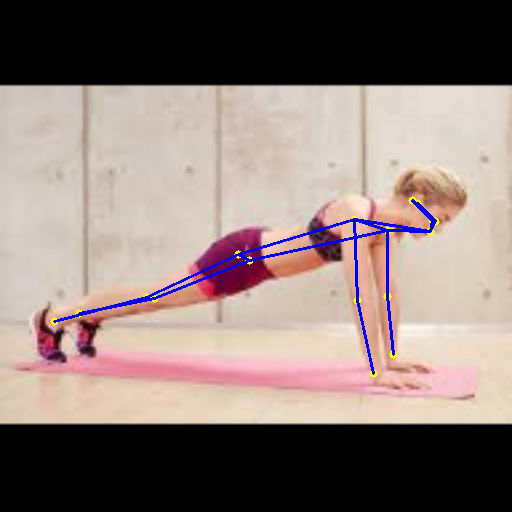

elbow angle: 174.96446547522805
back angle: 170.05259907314414
True False
True False
Reps: 0, Back: 1


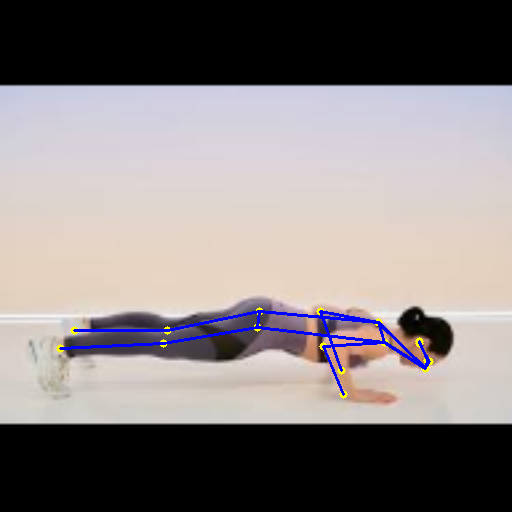

elbow angle: 59.47164325343935
back angle: 162.77737734716672
True False
down
False True
Reps: 0, Back: 1


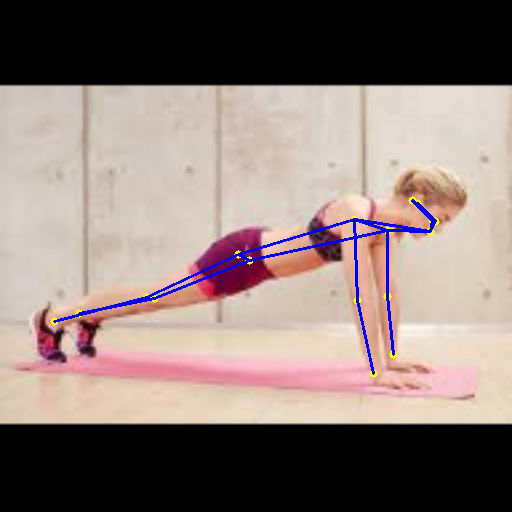

elbow angle: 174.96446547522805
back angle: 170.05259907314414
up
True False
True False
Reps: 1, Back: 1


In [ ]:
pushup_rep = 0
for img in images1:
  input_image, keypoints_tensor = predict_keypoints(movenet_model, img)
  keypoints_array = getKeypoints(keypoints_tensor)

  # display the image with keypoints
  display_keypoints(input_image, keypoints_tensor)

  # update arm and back angle
  elbow_angle = armAngle(keypoints_array)
  print("elbow angle:", elbow_angle)
  back_angle = backAngle(keypoints_array)
  print("back angle:", back_angle)

  pushup_rep = up_pushup(elbow_angle, pushup_rep)
  print(is_up_pushup, is_down_pushup)
  _ = down_pushup(elbow_angle)
  print(is_up_pushup, is_down_pushup)

  status_p = checkPushup(back_angle)

  print("Reps: {}, Back: {}".format(pushup_rep, status_p))

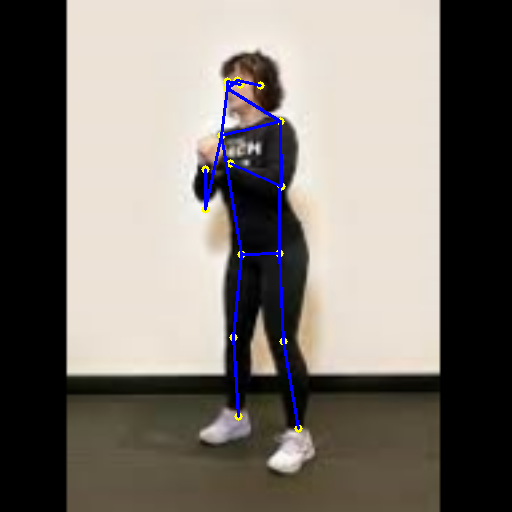

knee angle 172.87610319769993
hip angle: 176.6863466247625
True False
True False
Reps: 0


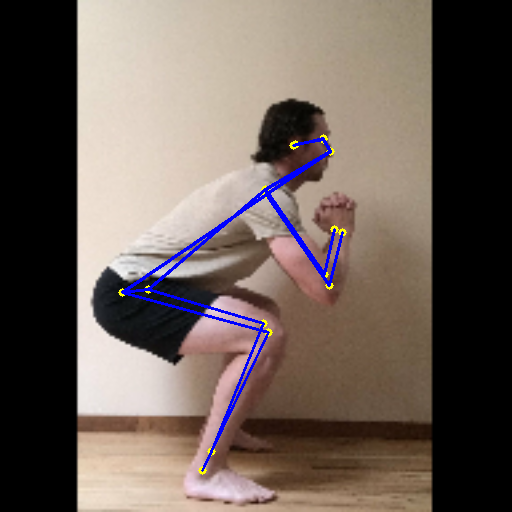

knee angle 275.54434349626774
hip angle: 57.1070864624857
True False
down
False True
Reps: 0


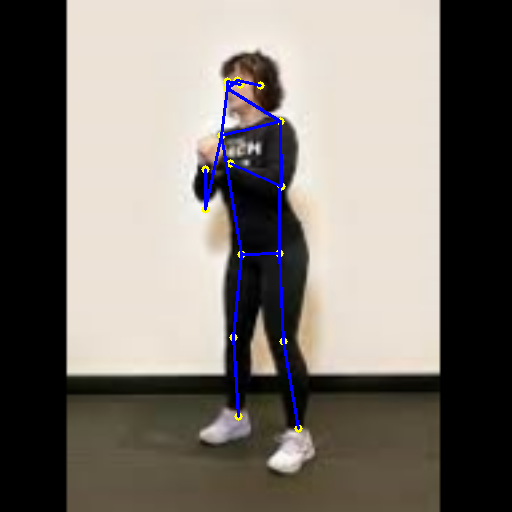

knee angle 172.87610319769993
hip angle: 176.6863466247625
up
True False
True False
Reps: 1


In [ ]:
squat_rep = 0
for img in images2:
  input_image, keypoints_tensor = predict_keypoints(movenet_model, img)
  keypoints_array = getKeypoints(keypoints_tensor)

  # display the image with keypoints
  display_keypoints(input_image, keypoints_tensor)

  # update arm and back angle
  knee_angle = kneeAngle(keypoints_array)
  print("knee angle", knee_angle)
  hip_angle = hipAngle(keypoints_array)
  print("hip angle:", hip_angle)

  squat_rep = up_squat(knee_angle, squat_rep)
  print(is_up_squat, is_down_squat)
  _ = down_squat(knee_angle)
  print(is_up_squat, is_down_squat)

  # status_s = checkSquat(hip_angle)

  # print("Reps: {}, Hip: {}".format(squat_rep, status_s))
  print("Reps: {}".format(squat_rep))